# GAN (Generative Adversarial Network)
## Генеративно-состязательная нейросеть

In [ ]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from random import shuffle
from itertools import cycle

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [ ]:
def func_y(x):
    if not hasattr(x, "__len__"):
        x = np.array([x])
    else:
        x = np.array(x)
    y = np.ones(x.shape[0])
    nz = np.argwhere(x != 0)
    y[nz] = (np.sin(x[nz])/x[nz]) - (x[nz]/10)
    return y if len(x) != 1 else y[0]
    # на самом деле в точке x=0 функция не определена, 
    # но стремится к 1, при приблежении x к нулю с любой из сторон

Обучающие данные представлены в виде функции, которая возвращает случайную точку функции в виде пары координат x и y в интервале значений (по координатной оси x) от low до high.

In [ ]:
def train_data(low=-10, high=10):
    x = np.random.uniform(low, high)
    y = func_y(x)
    return torch.Tensor([x,y])

train_ds = [train_data() for _ in range(3000)]
#train_ds = cycle(train_ds)

Генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1,10),
            nn.ReLU(),
            nn.Linear(10,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,2)
        )

    def forward(self, z):
        return self.model(z)


Дискриминатор 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2,70),
            nn.ReLU(),
            nn.Linear(70,70),
            nn.ReLU(),
            nn.Linear(70,1),
            nn.Sigmoid()
        )
  

    def forward(self, img):
        return self.model(img)

Загрузка датасета

Инициализация

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters())
optimizer_D = torch.optim.Adam(discriminator.parameters())

adversarial_loss = torch.nn.BCELoss()


EPOCHS = 100

glossh=[]
dlossh=[]

for epoch in range(EPOCHS):
    shuffle(train_ds)
    for real_xy in train_ds:
        real_xy = real_xy.to(device)
####    ############# Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(1).fill_(0.0), requires_grad=False).to(device)
    
####    ##############  Тренировка генератора    ##########################
        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (1)))).to(device)
        gen_imgs = generator(z)
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        
        g_loss.backward()
        optimizer_G.step()
####    ##############  Тренировка дискриминатора    ##########################
        optimizer_D.zero_grad()
    
        real_pred = discriminator(real_xy)
        d_real_loss = adversarial_loss(real_pred, valid)
        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        

        d_loss.backward()
        optimizer_D.step()
    
    glossh.append(g_loss.detach())
    dlossh.append(d_loss.detach())
    if epoch % (EPOCHS/10) == 0:
        print('epoch', epoch, 'из', EPOCHS, epoch*100/EPOCHS, '%')
                

epoch 0 из 100 0.0 %
epoch 10 из 100 10.0 %
epoch 20 из 100 20.0 %
epoch 30 из 100 30.0 %
epoch 40 из 100 40.0 %
epoch 50 из 100 50.0 %
epoch 60 из 100 60.0 %
epoch 70 из 100 70.0 %
epoch 80 из 100 80.0 %
epoch 90 из 100 90.0 %


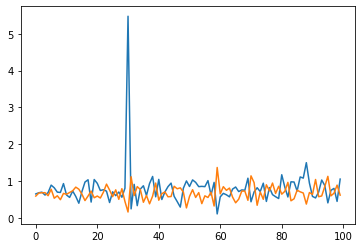

In [ ]:
plt.plot(glossh)
plt.plot(dlossh)

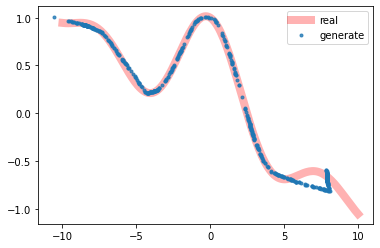

In [ ]:
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (500,1)))).to(device)


x = np.linspace(-10, 10, 201)
plt.plot(x, func_y(x), 'r', linewidth=8, alpha=0.3, label='real')


pred = generator(z).detach().numpy()
plt.plot(pred[:,0], pred[:,1], '.', linewidth=1, alpha=0.8, label='generate')
plt.legend()

Домашнее задание: 

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю
 

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.


